In [64]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from scipy.stats import gaussian_kde as kde
from scipy.interpolate import UnivariateSpline as spline

from ML_functions import *


First, load data and PCA decomposition:

In [51]:
spectra, seednum, gval=load_spectra('data/nn_arfs_fake_xifu_ngc1275_11June22.hdf5')
pcafile='pca_nn.npz'
U,A,V=load_pca(pcafile)

Loading spectra from file data/nn_arfs_fake_xifu_ngc1275_11June22.hdf5


Now, we can load a set of ANNs, and get estimates for G for all of these spectra with no signal to obtain a posterior distribution of G for each spectrum. 

For proof of concept, I'm using the 200 networks I was using to optimise the hyperparameters. Because these ANNs all have different sized input layers, we have to truncate to a different number of PCs each time. I'm also only using those networks that have a mean-squared error less than a threshold value.

In [36]:
# load all the information about network performance:
df=pd.read_csv('hpars2.csv',index_col=0)

# load each ANN in turn
N_hpars=200
gs_array=[]
for i in range(0,N_hpars):
	N_PCs=df['Npcs'][i]
	mse=df['mse'][i]
	# check MSE is below cutoff
	if mse<=0.025:
		# load model and evaluate G for test data
		loaded_model = load_model("model_%s" % str(i),'networks/hpars_opt/')
		gs_array.append(loaded_model.predict(truncate_pca(U,N_PCs))[10000:,0])

gs_array=np.array(gs_array)


Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 787us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 697us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 664us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 592us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 798us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 558us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 561us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 601us/step

Loading model from disk...
Compiling model...
375/375 [==============================] - 0s 556us/step

Loading model from disk...
Compiling model...
375/375 [========

We should now have a posterior distribution with N estimates of G for each of 2000 test spectra. If we look at the distribution of G estimates for those with G_sim>13.5 (i.e. those with no signal at all), we get the uncertainty in the networks:

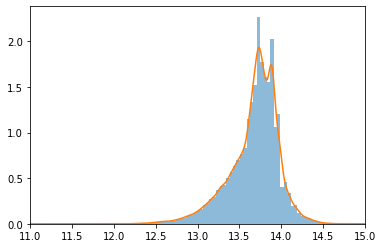

In [71]:
gs_filtered=gs_array[:,(gval[10000:]>13.5)]

ax=pl.subplot(111)
ax.set_xlim(11,15)

# plot histogram
pl.hist(gs_filtered.flatten()*4+11,bins=np.linspace(11,15,100),alpha=0.5,density=True)

# plot kde
density=kde(gs_filtered.flatten()*4+11)
gs=np.linspace(11,15,1000)
pl.plot(gs,density.pdf(gs))
pl.show()

We can now estimate a 95% limit from this:

95% limit: 13.10


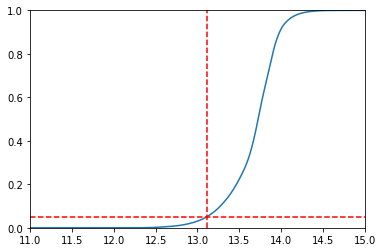

In [77]:
ax=pl.subplot(111)
ax.set_xlim(11,15)
ax.set_ylim(0,1)

# find and plot CDF
cdf=np.cumsum(density.pdf(gs))
cdf=cdf/max(cdf)
pl.plot(gs,cdf)
pl.plot([11,15],[0.05,0.05],color='r',ls='dashed')

# lovely spline, we love splines
cdf_spline=spline(gs,cdf-0.05,s=0)
limit=cdf_spline.roots()[0]

pl.plot([limit,limit],[0,1],color='r',ls='dashed')

print(r'95% limit:',str(limit)[:5])